In [3]:
import datetime
import matplotlib
import matplotlib.pyplot as plt
import os
import random
import io
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import tensorflow as tf
import pathlib
import itertools
import random

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

from object_detection.utils import config_util
from object_detection.builders import model_builder
%matplotlib inline
current_datetime=datetime.datetime.now()
print(f"Calf was last happy on: {current_datetime.strftime('%Y-%m-%d %H:%M:%S')}")

Calf was last happy on: 2023-09-19 16:45:05


In [4]:
!nvidia-smi
print(tf.config.list_physical_devices('GPU'))
# Optimization:
# tf.keras.mixed_precision.set_global_policy('mixed_float16')
gpu_memory_fraction = 0.8
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=int(gpu_memory_fraction * 1024))]
            )
    except RuntimeError as e:
        print(e)


Tue Sep 19 16:45:05 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|


|   0  NVIDIA GeForce RTX 3080        On  | 00000000:3E:00.0 Off |                  N/A |
| 30%   32C    P8              18W / 300W |      5MiB / 10240MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|  No running processes found                                                           |
+---------

In [5]:
# Training the model EfficienDetD1
!python3 Calf_Detection/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path=Calf_Detection/new_app/New_Models/config/efficientdet_d2_coco17_tpu-32.config \
    --model_dir=Calf_Detection/new_app/New_Models/training/efficientdet_d2_coco17_tpu-32 \
    --alsologtostderr

# Export the model EfficienDetD1
pipeline_file = 'Calf_Detection/new_app/New_Models/config/efficientdet_d2_coco17_tpu-32.config'
last_model_path = 'Calf_Detection/new_app/New_Models/training/efficientdet_d2_coco17_tpu-32'
output_directory = "Calf_Detection/new_app/New_Models/finetuned/efficientdet_d2_coco17_tpu-32"
!python3 Calf_Detection/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

2023-09-19 16:45:05.960829: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-19 16:45:06.010844: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 16:45:08.169470: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-19 16:45:13.714925: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8251 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:3e:00.0, compute capa

2023-09-19 16:53:33.980176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 819 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:3e:00.0, compute capability: 8.6


Calf_Detection/new_app/New_Models/training/efficientdet_d2_coco17_tpu-32/ckpt-2


2023-09-19 16:54:01.920406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-09-19 16:54:02.184993: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-19 16:54:02.679273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


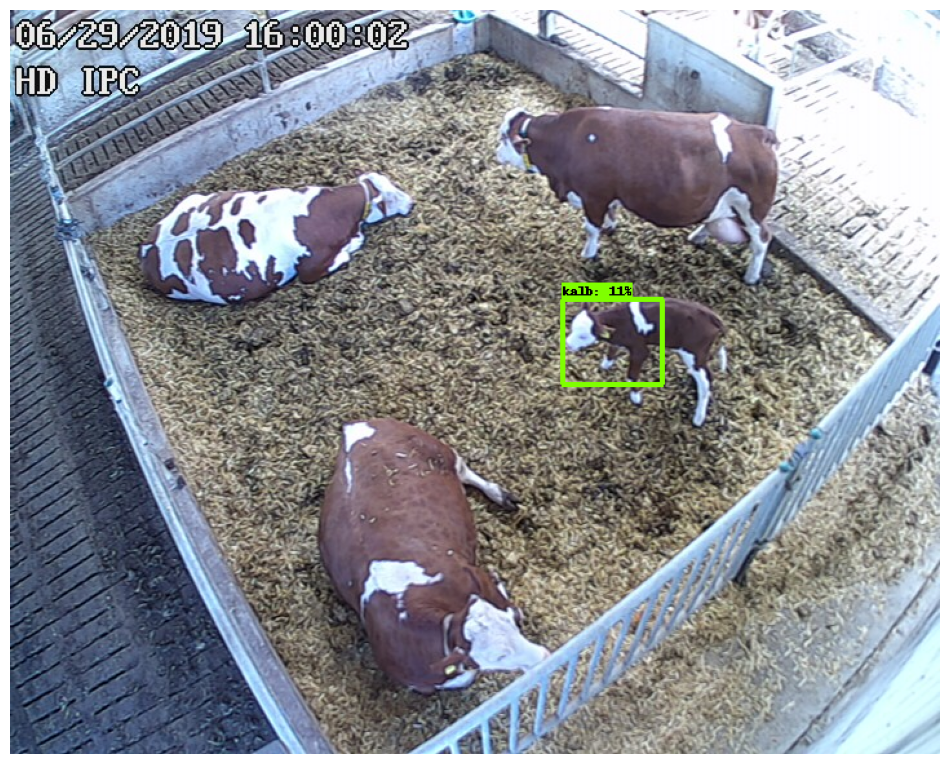

In [6]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.
  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.
  Args:
    path: a file path.
  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

filenames = list(pathlib.Path('Calf_Detection/new_app/New_Models/training/efficientdet_d2_coco17_tpu-32').glob('*.index'))

filenames.sort()

# recover our saved model
model_dir = 'Calf_Detection/new_app/New_Models/training/efficientdet_d2_coco17_tpu-32'
# Adding the last checkpoint
pipeline_file = 'Calf_Detection/new_app/New_Models/config/efficientdet_d2_coco17_tpu-32.config'
configs = config_util.get_configs_from_pipeline_file(pipeline_file)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

print(detection_model)
# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index',''))).expect_partial()
print(os.path.join(str(filenames[-1]).replace('.index','')))

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)    
# map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 

TEST_IMAGE_PATHS = glob.glob('Calf_Detection/new_app/test/2019-06-29_090001.jpg')
image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array(image_path)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=1,
      min_score_thresh=.1,
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.axis("off")
plt.show()

In [7]:
!python3 Calf_Detection/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path=Calf_Detection/new_app/New_Models/config/efficientdet_d1_coco17_tpu-32.config \
    --model_dir=Calf_Detection/new_app/New_Models/training/efficientdet_d1_coco17_tpu-32 \
    --checkpoint_dir=Calf_Detection/new_app/New_Models/training/efficientdet_d1_coco17_tpu-32 \
    --alsologtostderr

2023-09-19 16:54:05.028356: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-19 16:54:05.085612: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 16:54:09.961635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
W0919 16:54:22.751012 139793468338816 model_lib_v2.py:1089] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0919 16:54:22.751200 139793468338816 config_util.py:552] Maybe 

: 